# Modules Versions

In [1]:
# Import necessary libraries
import pandas as pd   # For data manipulation and analysis
import numpy as np    # For numerical computations
import seaborn as sns   # For data visualization
import matplotlib    # For plotting graphs
import warnings      # To handle warnings
import sklearn       # For machine learning algorithms and utilities
import xgboost as xgb    # For XGBoost machine learning library
import lightgbm as lgb   # For LightGBM machine learning library
import catboost      # For CatBoost machine learning library
import dill          # For serializing Python objects
import sys           # For system-specific parameters and functions

# Check Python version
print("Python version:", sys.version)

# Check versions of the imported libraries
print("Pandas version:", pd.__version__)         # Pandas version check
print("NumPy version:", np.__version__)          # NumPy version check
print("Seaborn version:", sns.__version__)       # Seaborn version check
print("Matplotlib version:", matplotlib.__version__)  # Matplotlib version check
print("Scikit-learn version:", sklearn.__version__)   # Scikit-learn version check
print("XGBoost version:", xgb.__version__)       # XGBoost version check
print("LightGBM version:", lgb.__version__)      # LightGBM version check
print("CatBoost version:", catboost.__version__) # CatBoost version check
print("Dill version:", dill.__version__)         # Dill version check

Python version: 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.2.2
NumPy version: 1.26.4
Seaborn version: 0.13.2
Matplotlib version: 3.9.2
Scikit-learn version: 1.5.1
XGBoost version: 2.1.1
LightGBM version: 4.5.0
CatBoost version: 1.2.5
Dill version: 0.3.8


#### My System Modules versions

#### Please install these version of the modules to run this code without error.

Python version: `3.11.9` [MSC v.1916 64 bit (AMD64)]

Pandas version: `2.2.2`

NumPy version: `1.26.4`

Seaborn version: `0.13.2`

Matplotlib version: `3.9.2`

Scikit-learn version: `1.5.1`

XGBoost version: `2.1.1`

LightGBM version: `4.5.0`

CatBoost version: `1.2.5`

Dill version: `0.3.8`

# Importing Libraries

In [2]:
# Importing essential libraries for data manipulation and visualization
import pandas as pd     # For data manipulation (DataFrames)
import numpy as np      # For numerical operations
import seaborn as sns   # For statistical data visualization
import matplotlib.pyplot as plt  # For plotting graphs

# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

# Importing functions for splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Importing the SimpleImputer to handle missing data
from sklearn.impute import SimpleImputer

# Importing the StandardScaler to standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Importing machine learning models from popular libraries
from xgboost import XGBClassifier      # XGBoost classifier
from lightgbm import LGBMClassifier    # LightGBM classifier
from catboost import CatBoostClassifier  # CatBoost classifier

# Importing various evaluation metrics for classification tasks
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, log_loss, balanced_accuracy_score
from sklearn.metrics import classification_report  # To get a detailed classification report

# Importing FunctionTransformer to create custom transformations for pipelines
from sklearn.preprocessing import FunctionTransformer

# BaseEstimator and ClassifierMixin are used for creating custom classifiers in scikit-learn
from sklearn.base import BaseEstimator, ClassifierMixin

# Importing Pipeline to chain multiple steps such as preprocessing and model fitting into one object
from sklearn.pipeline import Pipeline

# Dill is used for serializing Python objects, helpful for saving models and pipelines
import dill

# Importing RocCurveDisplay to visually display the ROC curve for a classifier
from sklearn.metrics import RocCurveDisplay

# Loading Data

In [3]:
# Load training data from CSV files
x_train_final = pd.read_csv("X_Train_Data_Input.csv")   # Load features for training set
y_train_final = pd.read_csv("Y_Train_Data_Target.csv")  # Load target labels for training set

# Split the data into training and validation sets
x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(
    x_train_final,              # Input features
    y_train_final,              # Target labels
    test_size=0.2,              # 20% of the data for validation
    random_state=42,            # Ensures reproducibility of the split
    stratify=y_train_final['target']  # Stratify based on target variable to maintain class distribution
)

# Reset the index of the training and validation sets to avoid index misalignment after splitting
x_train_final.reset_index(drop=True, inplace=True)   # Reset index for training features
x_val_final.reset_index(drop=True, inplace=True)     # Reset index for validation features
y_train_final.reset_index(drop=True, inplace=True)   # Reset index for training target
y_val_final.reset_index(drop=True, inplace=True)     # Reset index for validation target

# Load test data from CSV files
x_test_final = pd.read_csv("X_Test_Data_Input.csv")   # Load features for test set
y_test_final = pd.read_csv("Y_Test_Data_Target.csv")  # Load target labels for test set

# Model Pipeline Building

In [4]:
# Custom voting classifier class that implements majority voting between models
class CustomVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        # Initialize with a dictionary of model names and their instances
        self.models = models  # Dictionary where keys are model names and values are model objects
        self.model_names = list(models.keys())  # Store the model names as a list for reference

    def _convert_to_dataframe(self, X, y=None):
        """Helper function to convert input to a DataFrame if it's not already one."""
        if not isinstance(X, pd.DataFrame):  # Check if X is already a DataFrame
            X = pd.DataFrame(X)  # If not, convert X to DataFrame
        if y is not None and not isinstance(y, pd.DataFrame):  # Similarly, check for y
            y = pd.DataFrame(y)  # Convert y to DataFrame if it's provided and not already a DataFrame
        return X, y  # Return the processed X and y

    def fit(self, X, y):
        # Convert X and y to DataFrame if necessary
        X, y = self._convert_to_dataframe(X, y)

        # Fit each model in the dictionary using the training data
        for model in self.models.values():
            model.fit(X, y)  # Fit each individual model with X and y
        
        self.fitted_ = True  # Mark the classifier as fitted
        return self  # Return the fitted instance of the class

    def predict(self, X):
        # Convert X to DataFrame if needed
        X, _ = self._convert_to_dataframe(X)

        # Collect predictions from all models in the ensemble
        predictions = np.array([model.predict(X) for model in self.models.values()])

        # Majority voting: round the mean of the predictions across models
        return np.round(np.mean(predictions, axis=0)).astype(int)  # Return majority class predictions

    def predict_proba(self, X):
        # Convert X to DataFrame if needed
        X, _ = self._convert_to_dataframe(X)

        # Get prediction probabilities from each model in the ensemble
        probabilities = np.array([model.predict_proba(X) for model in self.models.values()])

        # Average the predicted probabilities across models
        return np.mean(probabilities, axis=0)  # Return the average probability predictions

In [5]:
# Function to drop specified columns from the DataFrame
def drop_columns(X):
    return X.drop(columns=['ID', 'Column9'])  # Drop 'ID' and 'Column9' from the DataFrame X

# Create a FunctionTransformer that wraps the drop_columns function
drop_columns_transformer = FunctionTransformer(drop_columns)  
# This allows you to use the drop_columns function in a scikit-learn pipeline

In [6]:
# Initialize a SimpleImputer to handle missing data by filling missing values with the median value
imputer = SimpleImputer(strategy='median')  
# The 'median' strategy replaces missing values with the median of each column

# Initialize a StandardScaler to standardize features
sc = StandardScaler()  
# StandardScaler scales the data to have zero mean and unit variance, making the features comparable

In [7]:
# Hyperparameter-tuned parameters for XGBoost model
xgb_params = {
    'colsample_bytree': 1,         # Fraction of features to consider for each tree
    'learning_rate': 0.1,          # Step size shrinkage to prevent overfitting
    'max_depth': 7,                # Maximum depth of a tree
    'n_estimators': 200,           # Number of boosting rounds (trees)
    'subsample': 1                 # Fraction of samples used for training each tree
}

# Hyperparameter-tuned parameters for LightGBM model
lightbgm_params = {
    'lambda_l1': 3.96,             # L1 regularization term
    'lambda_l2': 1.51,             # L2 regularization term
    'num_leaves': 90,              # Maximum number of leaves in one tree
    'feature_fraction': 0.97,      # Fraction of features to be randomly selected for each boosting round
    'bagging_fraction': 1.0,       # Fraction of data used for training each boosting round
    'bagging_freq': 2,             # Frequency of bagging; 2 means every 2 rounds
    'min_child_samples': 63        # Minimum number of data points required in a leaf node
}

# Hyperparameter-tuned parameters for CatBoost model
catboost_params = {
    'iterations': 700,                     # Number of boosting iterations
    'learning_rate': 0.1285,               # Learning rate for CatBoost
    'l2_leaf_reg': 0.837,                  # L2 regularization term for leaves
    'border_count': 171,                   # Number of splits for numerical features
    'bagging_temperature': 22.36,          # Controls sampling strength for bagging
    'random_strength': 1.399,              # Controls randomness in splits selection
    'boosting_type': 'Plain',              # Type of boosting ('Plain' or 'Ordered')
    'depth': 9,                            # Depth of the tree
    'grow_policy': 'SymmetricTree',        # Tree growing policy
    'eval_metric': 'F1',                   # Evaluation metric to be used during training
}

# Initialize models using the above hyperparameter settings
models = {
    'XGBClassifier': XGBClassifier(**xgb_params),  # XGBoost classifier with tuned parameters
    'CatBoostClassifier': CatBoostClassifier(**catboost_params, verbose=False),  # CatBoost classifier with tuned parameters
    'LGBMClassifier': LGBMClassifier(**lightbgm_params, verbose=-1)  # LightGBM classifier with tuned parameters
}

In [9]:
# Dictionary of final models
final_models = {
    'XGBClassifier': models['XGBClassifier'],      # XGBoost classifier from the models dictionary
    'CatBoostClassifier': models['CatBoostClassifier'],  # CatBoost classifier from the models dictionary
    'LGBMClassifier': models['LGBMClassifier']     # LightGBM classifier from the models dictionary
}
# Initialize the custom voting classifier with the final models
voting_clf = CustomVotingClassifier(models=final_models)  
# This creates an instance of CustomVotingClassifier, passing in the final_models dictionary,
# which contains the XGBoost, CatBoost, and LightGBM classifiers.

In [10]:
# Create a data processing and modeling pipeline
pipeline = Pipeline([
    ('drop_columns', drop_columns_transformer),  # Step to drop specified columns using FunctionTransformer
    ('imputer', imputer),                        # Step to impute missing values using SimpleImputer
    ('scaler', sc),                             # Step to scale features using StandardScaler
    ('voting', voting_clf)                      # Step to use the custom voting classifier for predictions
])

# Saving Pipeline

In [11]:
# Save the trained pipeline object to a file using dill
with open('best_pipeline_model.pkl', 'wb') as f:  # Open a file in write-binary mode
    dill.dump(pipeline, f)  # Serialize the 'pipeline' object and save it to the file

# Loading Pipeline

In [16]:
# Load the previously saved pipeline object from the file
with open('best_pipeline_model.pkl', 'rb') as f:  # Open the file in read-binary mode
    loaded = dill.load(f)  # Deserialize the pipeline object from the file and store it in 'loaded'

In [17]:
# Structure of the Model Pipeline
loaded

Pipeline(steps=[('drop_columns',
                 FunctionTransformer(func=<function drop_columns at 0x000002635B661A80>)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('voting',
                 CustomVotingClassifier(models={'CatBoostClassifier': <catboost.core.CatBoostClassifier object at 0x000002635B685950>,
                                                'LGBMClassifier': LGBMClassifier(bagging_fraction=1.0...
                                                                               grow_policy=None,
                                                                               importance_type=None,
                                                                               interaction_constraints=None,
                                                                               learning_rate=0.1,
                                                                               max_bin=None,
                                                                               max_cat_threshold=None,
                                                                               max_cat_to_onehot=None,
                                                                               max_delta_step=None,
                                                                               max_depth=7,
                                                                               max_leaves=None,
                                                                               min_child_weight=None,
                                                                               missing=nan,
                                                                               monotone_constraints=None,
                                                                               multi_strategy=None,
                                                                               n_estimators=200,
                                                                               n_jobs=None,
                                                                               num_parallel_tree=None,
                                                                               random_state=None, ...)}))])

# Pipeline Training

In [18]:
# Fit the loaded pipeline on the training data
loaded.fit(x_train_final, y_train_final.iloc[:, -1])  
# This trains the pipeline (including data preprocessing steps and the voting classifier) on the provided training features 'x_train_final'
# and the target variable 'y_train_final'. The '.iloc[:, -1]' selects the last column of 'y_train_final' as the target variable.

Pipeline(steps=[('drop_columns',
                 FunctionTransformer(func=<function drop_columns at 0x000002635B661A80>)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('voting',
                 CustomVotingClassifier(models={'CatBoostClassifier': <catboost.core.CatBoostClassifier object at 0x000002635B685950>,
                                                'LGBMClassifier': LGBMClassifier(bagging_fraction=1.0...
                                                                               grow_policy=None,
                                                                               importance_type=None,
                                                                               interaction_constraints=None,
                                                                               learning_rate=0.1,
                                                                               max_bin=None,
                                                                               max_cat_threshold=None,
                                                                               max_cat_to_onehot=None,
                                                                               max_delta_step=None,
                                                                               max_depth=7,
                                                                               max_leaves=None,
                                                                               min_child_weight=None,
                                                                               missing=nan,
                                                                               monotone_constraints=None,
                                                                               multi_strategy=None,
                                                                               n_estimators=200,
                                                                               n_jobs=None,
                                                                               num_parallel_tree=None,
                                                                               random_state=None, ...)}))])

# Resutls for Train, Validation And Testing Data

In [19]:
# Make predictions on the training data using the loaded pipeline
y_pred_train = loaded.predict(x_train_final)  
# This line uses the fitted pipeline to predict the target variable for the training features 'x_train_final'.
# The predictions are stored in 'y_pred_train'.

In [20]:
# Get predicted probabilities for the training data using the loaded pipeline
y_prob_train = loaded.predict_proba(x_train_final)  
# This line uses the fitted pipeline to compute the predicted probabilities for each class for the training features 'x_train_final'.
# The probabilities are stored in 'y_prob_train'.

In [21]:
# Calculate evaluation metrics for the training data
accuracy_train = accuracy_score(y_train_final['target'], y_pred_train)  # Calculate accuracy
precision_train = precision_score(y_train_final['target'], y_pred_train)  # Calculate precision
recall_train = recall_score(y_train_final['target'], y_pred_train)  # Calculate recall
f1_train = f1_score(y_train_final['target'], y_pred_train)  # Calculate F1 score
roc_auc_train = roc_auc_score(y_train_final['target'], y_pred_train)  # Calculate ROC AUC score
balanced_acc_train = balanced_accuracy_score(y_train_final['target'], y_pred_train)  # Calculate balanced accuracy
log_loss_train = log_loss(y_train_final['target'], y_prob_train)  # Calculate log loss
conf_matrix_train = confusion_matrix(y_train_final['target'], y_pred_train)  # Compute confusion matrix
class_report_train = classification_report(y_train_final['target'], y_pred_train)  # Generate classification report

# Print the evaluation results for training data
print('\tTraining Results\n')  # Print a header for training results
print(f"Accuracy: {accuracy_train}")  # Print accuracy
print(f"Precision: {precision_train}")  # Print precision
print(f"Recall: {recall_train}")  # Print recall
print(f"F1 Score: {f1_train}")  # Print F1 score
print(f"ROC AUC Score: {roc_auc_train}")  # Print ROC AUC score
print(f"Balanced Accuracy: {balanced_acc_train}")  # Print balanced accuracy
print(f"Log Loss: {log_loss_train}")  # Print log loss
print("\nConfusion Matrix:")  # Print header for confusion matrix
print(conf_matrix_train)  # Print confusion matrix
print("\nClassification Report:")  # Print header for classification report
print(class_report_train)  # Print classification report

	Training Results

Accuracy: 0.9819234333058433
Precision: 0.8688249252673426
Recall: 0.9520312025124101
F1 Score: 0.9085269569140537
ROC AUC Score: 0.9685333554398643
Balanced Accuracy: 0.9685333554398642
Log Loss: 0.04160348152455527

Confusion Matrix:
[[560367   8513]
 [  2841  56385]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    568880
           1       0.87      0.95      0.91     59226

    accuracy                           0.98    628106
   macro avg       0.93      0.97      0.95    628106
weighted avg       0.98      0.98      0.98    628106



In [22]:
# Make predictions on the validation dataset
y_pred_val = loaded.predict(x_val_final)  # Use the loaded pipeline to predict target values for the validation set
y_pred_val  # Display the predictions for the validation set

array([0, 0, 0, ..., 1, 0, 0])

In [23]:
# Calculate predicted probabilities on the validation dataset
y_prob_val = loaded.predict_proba(x_val_final)  # Use the loaded pipeline to predict probabilities for the validation set
y_prob_val  # Display the predicted probabilities for the validation set

array([[9.99995834e-01, 4.16758070e-06],
       [9.99994296e-01, 5.69856948e-06],
       [9.99995692e-01, 4.30247498e-06],
       ...,
       [1.15304296e-01, 8.84695704e-01],
       [9.99995713e-01, 4.28792491e-06],
       [9.99994395e-01, 5.59905622e-06]])

In [24]:
# Calculate evaluation metrics for the validation data
accuracy_val = accuracy_score(y_val_final['target'], y_pred_val)  # Calculate accuracy
precision_val = precision_score(y_val_final['target'], y_pred_val)  # Calculate precision
recall_val = recall_score(y_val_final['target'], y_pred_val)  # Calculate recall
f1_val = f1_score(y_val_final['target'], y_pred_val)  # Calculate F1 score
roc_auc_val = roc_auc_score(y_val_final['target'], y_pred_val)  # Calculate ROC AUC score
balanced_acc_val = balanced_accuracy_score(y_val_final['target'], y_pred_val)  # Calculate balanced accuracy
log_loss_val = log_loss(y_val_final['target'], y_prob_val)  # Calculate log loss using predicted probabilities
conf_matrix_val = confusion_matrix(y_val_final['target'], y_pred_val)  # Generate confusion matrix
class_report_val = classification_report(y_val_final['target'], y_pred_val)  # Generate classification report

# Print the evaluation results for the validation set
print('\tValidation Results\n')
print(f"Accuracy: {accuracy_val}")  # Print accuracy result
print(f"Precision: {precision_val}")  # Print precision result
print(f"Recall: {recall_val}")  # Print recall result
print(f"F1 Score: {f1_val}")  # Print F1 score result
print(f"ROC AUC Score: {roc_auc_val}")  # Print ROC AUC score result
print(f"Balanced Accuracy: {balanced_acc_val}")  # Print balanced accuracy result
print(f"Log Loss: {log_loss_val}")  # Print log loss result
print("\nConfusion Matrix:")  # Indicate the following output is the confusion matrix
print(conf_matrix_val)  # Print the confusion matrix
print("\nClassification Report:")  # Indicate the following output is the classification report
print(class_report_val)  # Print the classification report

	Validation Results

Accuracy: 0.9786151426187853
Precision: 0.8541292916795546
Recall: 0.9324643749577902
F1 Score: 0.8915794911532997
ROC AUC Score: 0.9579422141980625
Balanced Accuracy: 0.9579422141980626
Log Loss: 0.04883546668674139

Confusion Matrix:
[[139862   2358]
 [  1000  13807]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    142220
           1       0.85      0.93      0.89     14807

    accuracy                           0.98    157027
   macro avg       0.92      0.96      0.94    157027
weighted avg       0.98      0.98      0.98    157027



In [25]:
# Predict the target variable for the test set
y_pred_test_final = loaded.predict(x_test_final)

# Display the predictions
print("Test Predictions:")
print(y_pred_test_final)

Test Predictions:
[0 0 0 ... 0 0 0]


In [26]:
# Predict probabilities for the test set
y_prob_test_final = loaded.predict_proba(x_test_final)

# Display the predicted probabilities
print("Test Predicted Probabilities:")
print(y_prob_test_final)

Test Predicted Probabilities:
[[9.99994424e-01 5.57953941e-06]
 [9.99994808e-01 5.19452510e-06]
 [9.99994386e-01 5.62219612e-06]
 ...
 [9.99994578e-01 5.42942116e-06]
 [9.99994362e-01 5.64670443e-06]
 [9.99993790e-01 6.20034251e-06]]


In [27]:
# Calculate evaluation metrics for the test dataset
accuracy_test = accuracy_score(y_test_final['target'], y_pred_test_final)  # Calculate accuracy
precision_test = precision_score(y_test_final['target'], y_pred_test_final)  # Calculate precision
recall_test = recall_score(y_test_final['target'], y_pred_test_final)  # Calculate recall
f1_test = f1_score(y_test_final['target'], y_pred_test_final)  # Calculate F1 score
roc_auc_test = roc_auc_score(y_test_final['target'], y_pred_test_final)  # Calculate ROC AUC score
balanced_acc_test = balanced_accuracy_score(y_test_final['target'], y_pred_test_final)  # Calculate balanced accuracy
log_loss_test = log_loss(y_test_final['target'], y_prob_test_final)  # Calculate log loss
conf_matrix_test = confusion_matrix(y_test_final['target'], y_pred_test_final)  # Create confusion matrix
class_report_test = classification_report(y_test_final['target'], y_pred_test_final)  # Generate classification report

# Print the evaluation results for the test dataset
print('\tTesting Results\n')
print(f"Accuracy: {accuracy_test}")  # Display accuracy
print(f"Precision: {precision_test}")  # Display precision
print(f"Recall: {recall_test}")  # Display recall
print(f"F1 Score: {f1_test}")  # Display F1 score
print(f"ROC AUC Score: {roc_auc_test}")  # Display ROC AUC score
print(f"Balanced Accuracy: {balanced_acc_test}")  # Display balanced accuracy
print(f"Log Loss: {log_loss_test}")  # Display log loss
print("\nConfusion Matrix:")  # Indicate confusion matrix output
print(conf_matrix_test)  # Print confusion matrix
print("\nClassification Report:")  # Indicate classification report output
print(class_report_test)  # Print classification report

	Testing Results

Accuracy: 0.9785833282386746
Precision: 0.8502846648301193
Recall: 0.938041980711565
F1 Score: 0.892010095755544
ROC AUC Score: 0.9604230676948984
Balanced Accuracy: 0.9604230676948984
Log Loss: 0.049016532015078614

Confusion Matrix:
[[232958   4076]
 [  1529  23149]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.85      0.94      0.89     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.94    261712
weighted avg       0.98      0.98      0.98    261712



# Feature Improtance

In [30]:
# Step 1: Get feature importances from each model
# Extracting feature importances for each classifier in the voting ensemble
xgb_importance = loaded.named_steps['voting'].models['XGBClassifier'].feature_importances_  # Feature importances from XGBClassifier
cat_importance = loaded.named_steps['voting'].models['CatBoostClassifier'].get_feature_importance()  # Feature importances from CatBoostClassifier
lgb_importance = loaded.named_steps['voting'].models['LGBMClassifier'].feature_importances_  # Feature importances from LGBMClassifier

# Step 2: Normalize the importances
# Normalize feature importances to the range [0, 1] using MinMaxScaler
scaler = MinMaxScaler()  # Initialize the scaler
xgb_importance = scaler.fit_transform(xgb_importance.reshape(-1, 1)).flatten()  # Normalize XGB feature importances
cat_importance = scaler.fit_transform(cat_importance.reshape(-1, 1)).flatten()  # Normalize CatBoost feature importances
lgb_importance = scaler.fit_transform(lgb_importance.reshape(-1, 1)).flatten()  # Normalize LGBM feature importances

# Step 3: Combine the importances (using average here)
# Average the normalized importances to create a combined importance score
avg_importance = (xgb_importance + cat_importance + lgb_importance) / 3

# Step 4: Create DataFrame for visualization
# Define the feature names corresponding to the importances
columns = ['Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
           'Column6', 'Column7', 'Column8', 'Column10', 'Column11', 'Column12', 
           'Column13', 'Column14', 'Column15', 'Column16', 'Column17', 'Column18', 
           'Column19', 'Column20', 'Column21']

feature_names = columns  # Assign feature names

# Create a DataFrame with features and their averaged importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
})

# Sort the DataFrame by importance in descending order for visualization
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
feature_importance_df

,Feature,Importance
17,Column18,0.722910
1,Column1,0.364432
2,Column2,0.289028
7,Column7,0.176185
8,Column8,0.154608
13,Column14,0.121595
3,Column3,0.114607
4,Column4,0.098526
6,Column6,0.075401
5,Column5,0.072717


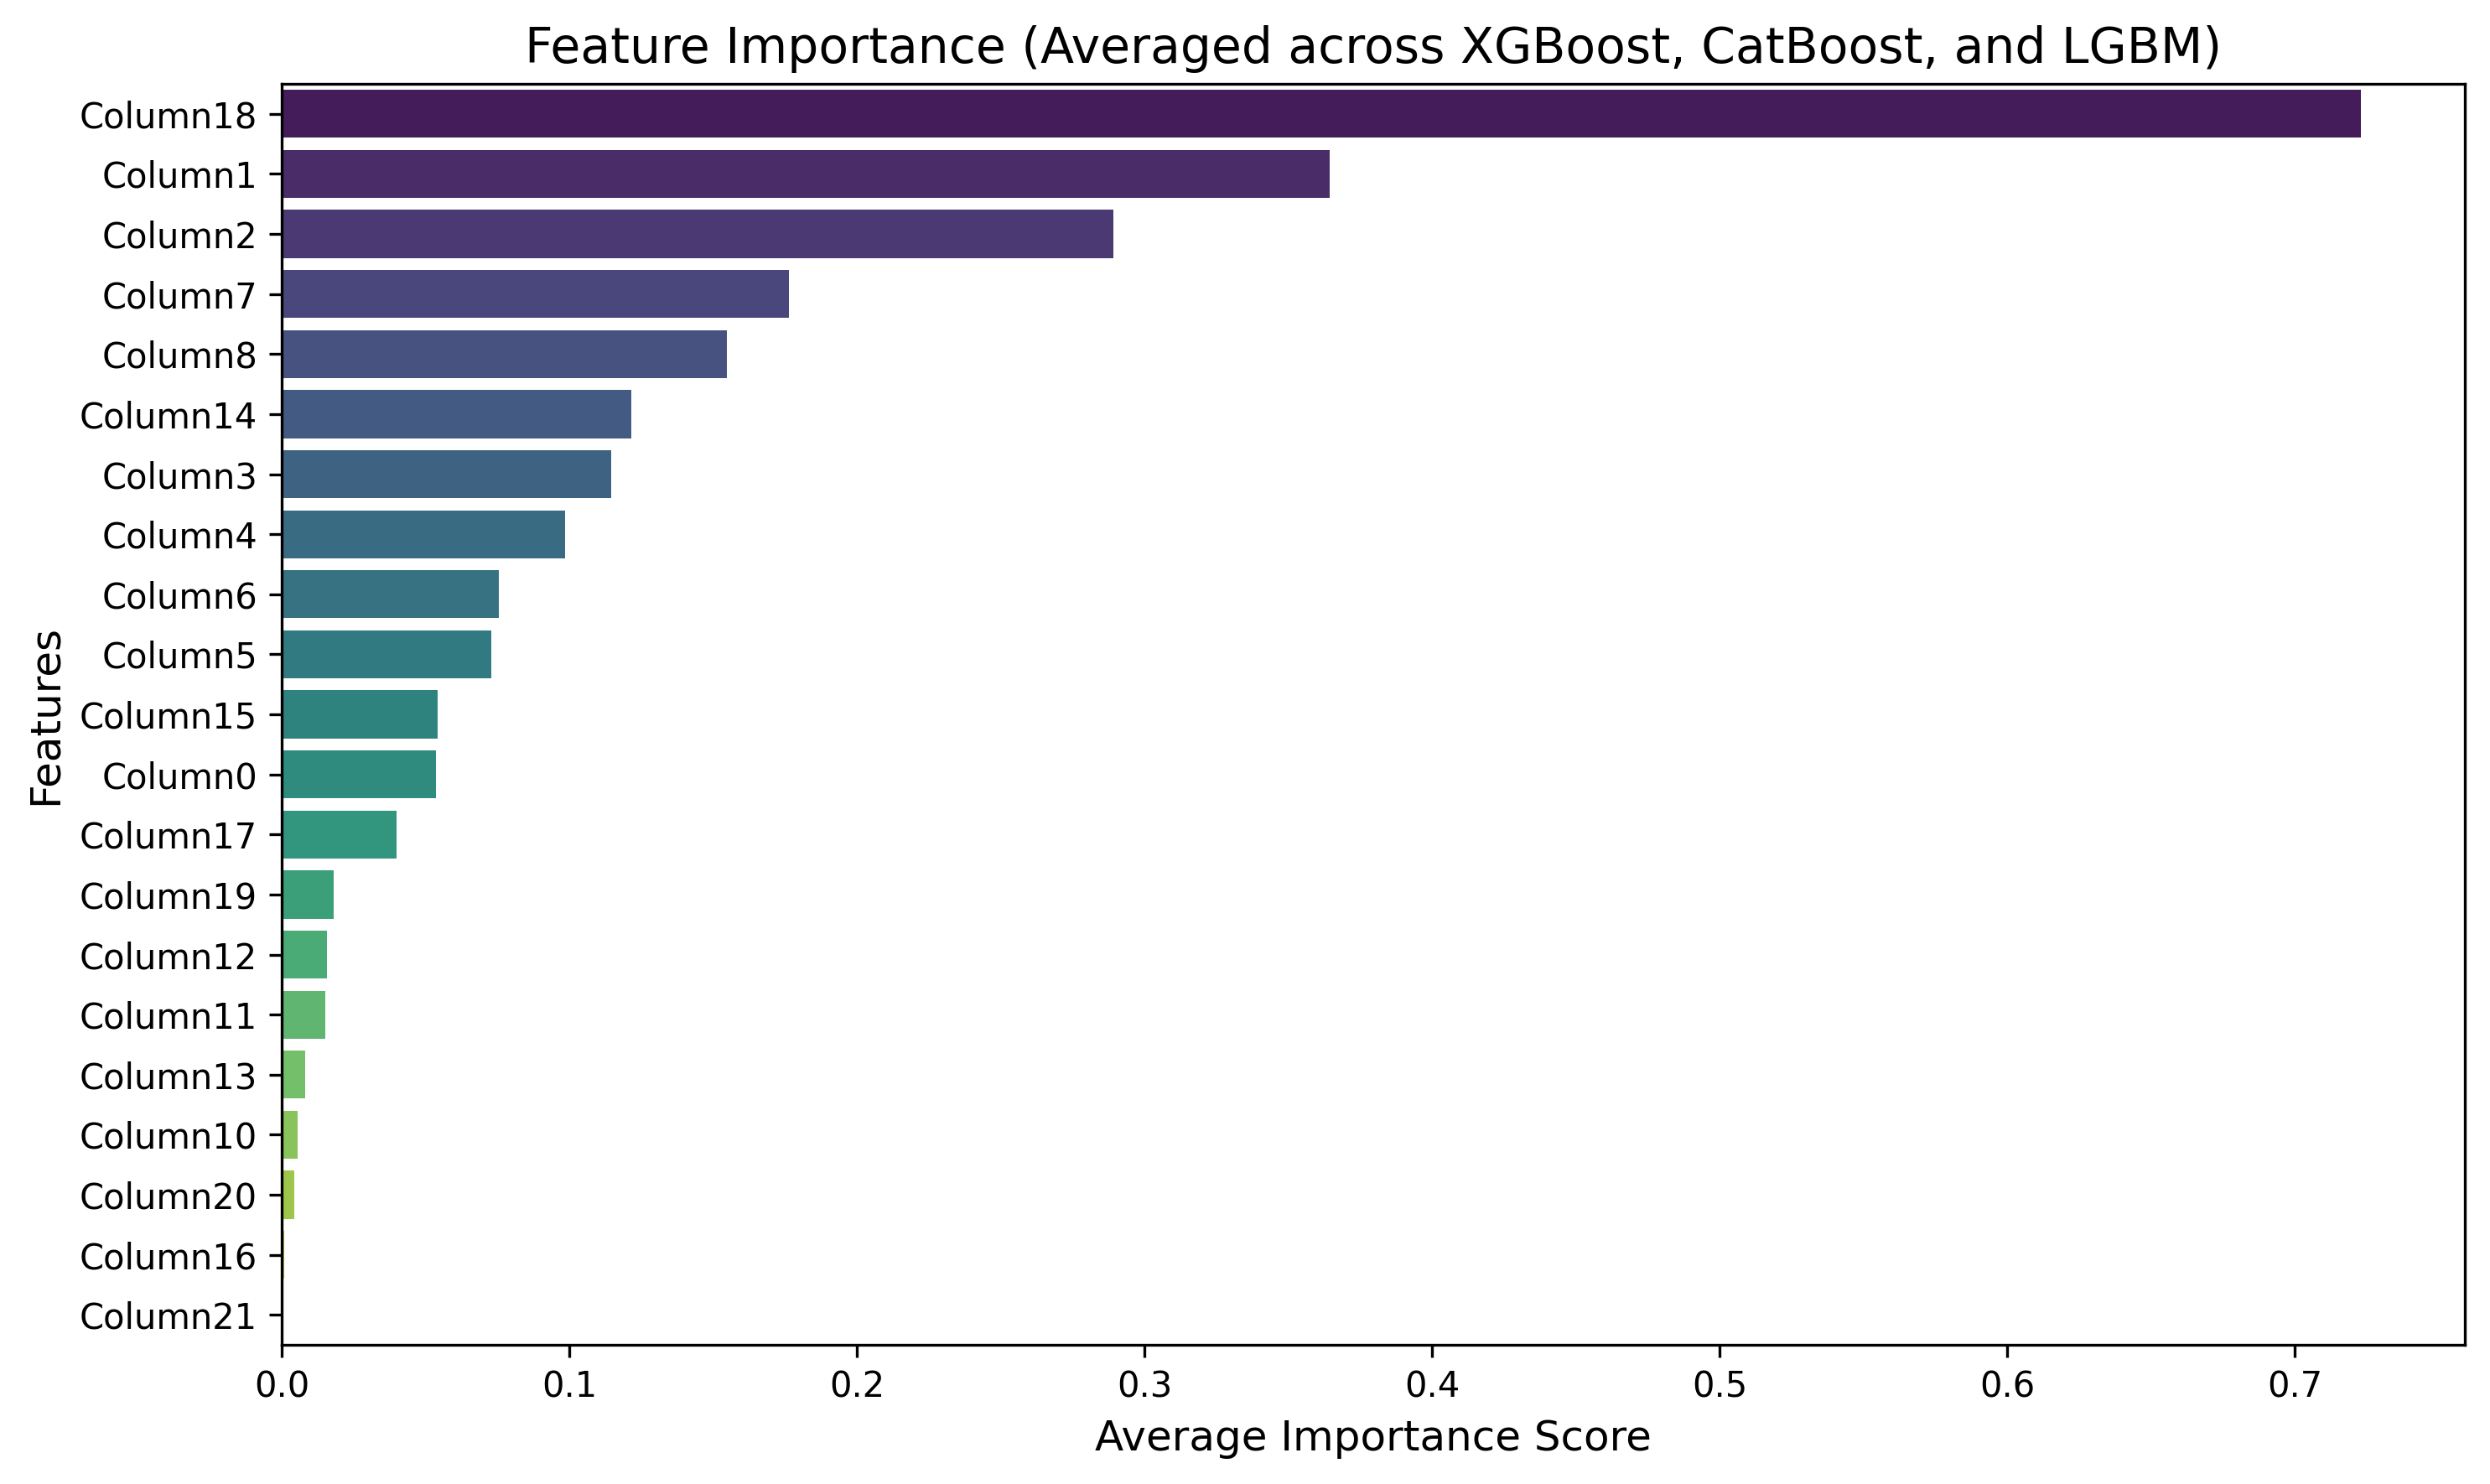

In [31]:
# Step 1: Plot the feature importance using Seaborn's barplot
plt.figure(figsize=(10, 6), dpi=300)  # Set figure size and resolution
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

# Step 2: Add titles and labels
plt.title('Feature Importance (Averaged across XGBoost, CatBoost, and LGBM)', fontsize=14)
plt.xlabel('Average Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Step 3: Improve layout for better readability
plt.tight_layout()

# Step 4: Show the plot
plt.show()

# Graphical Representation Of Results

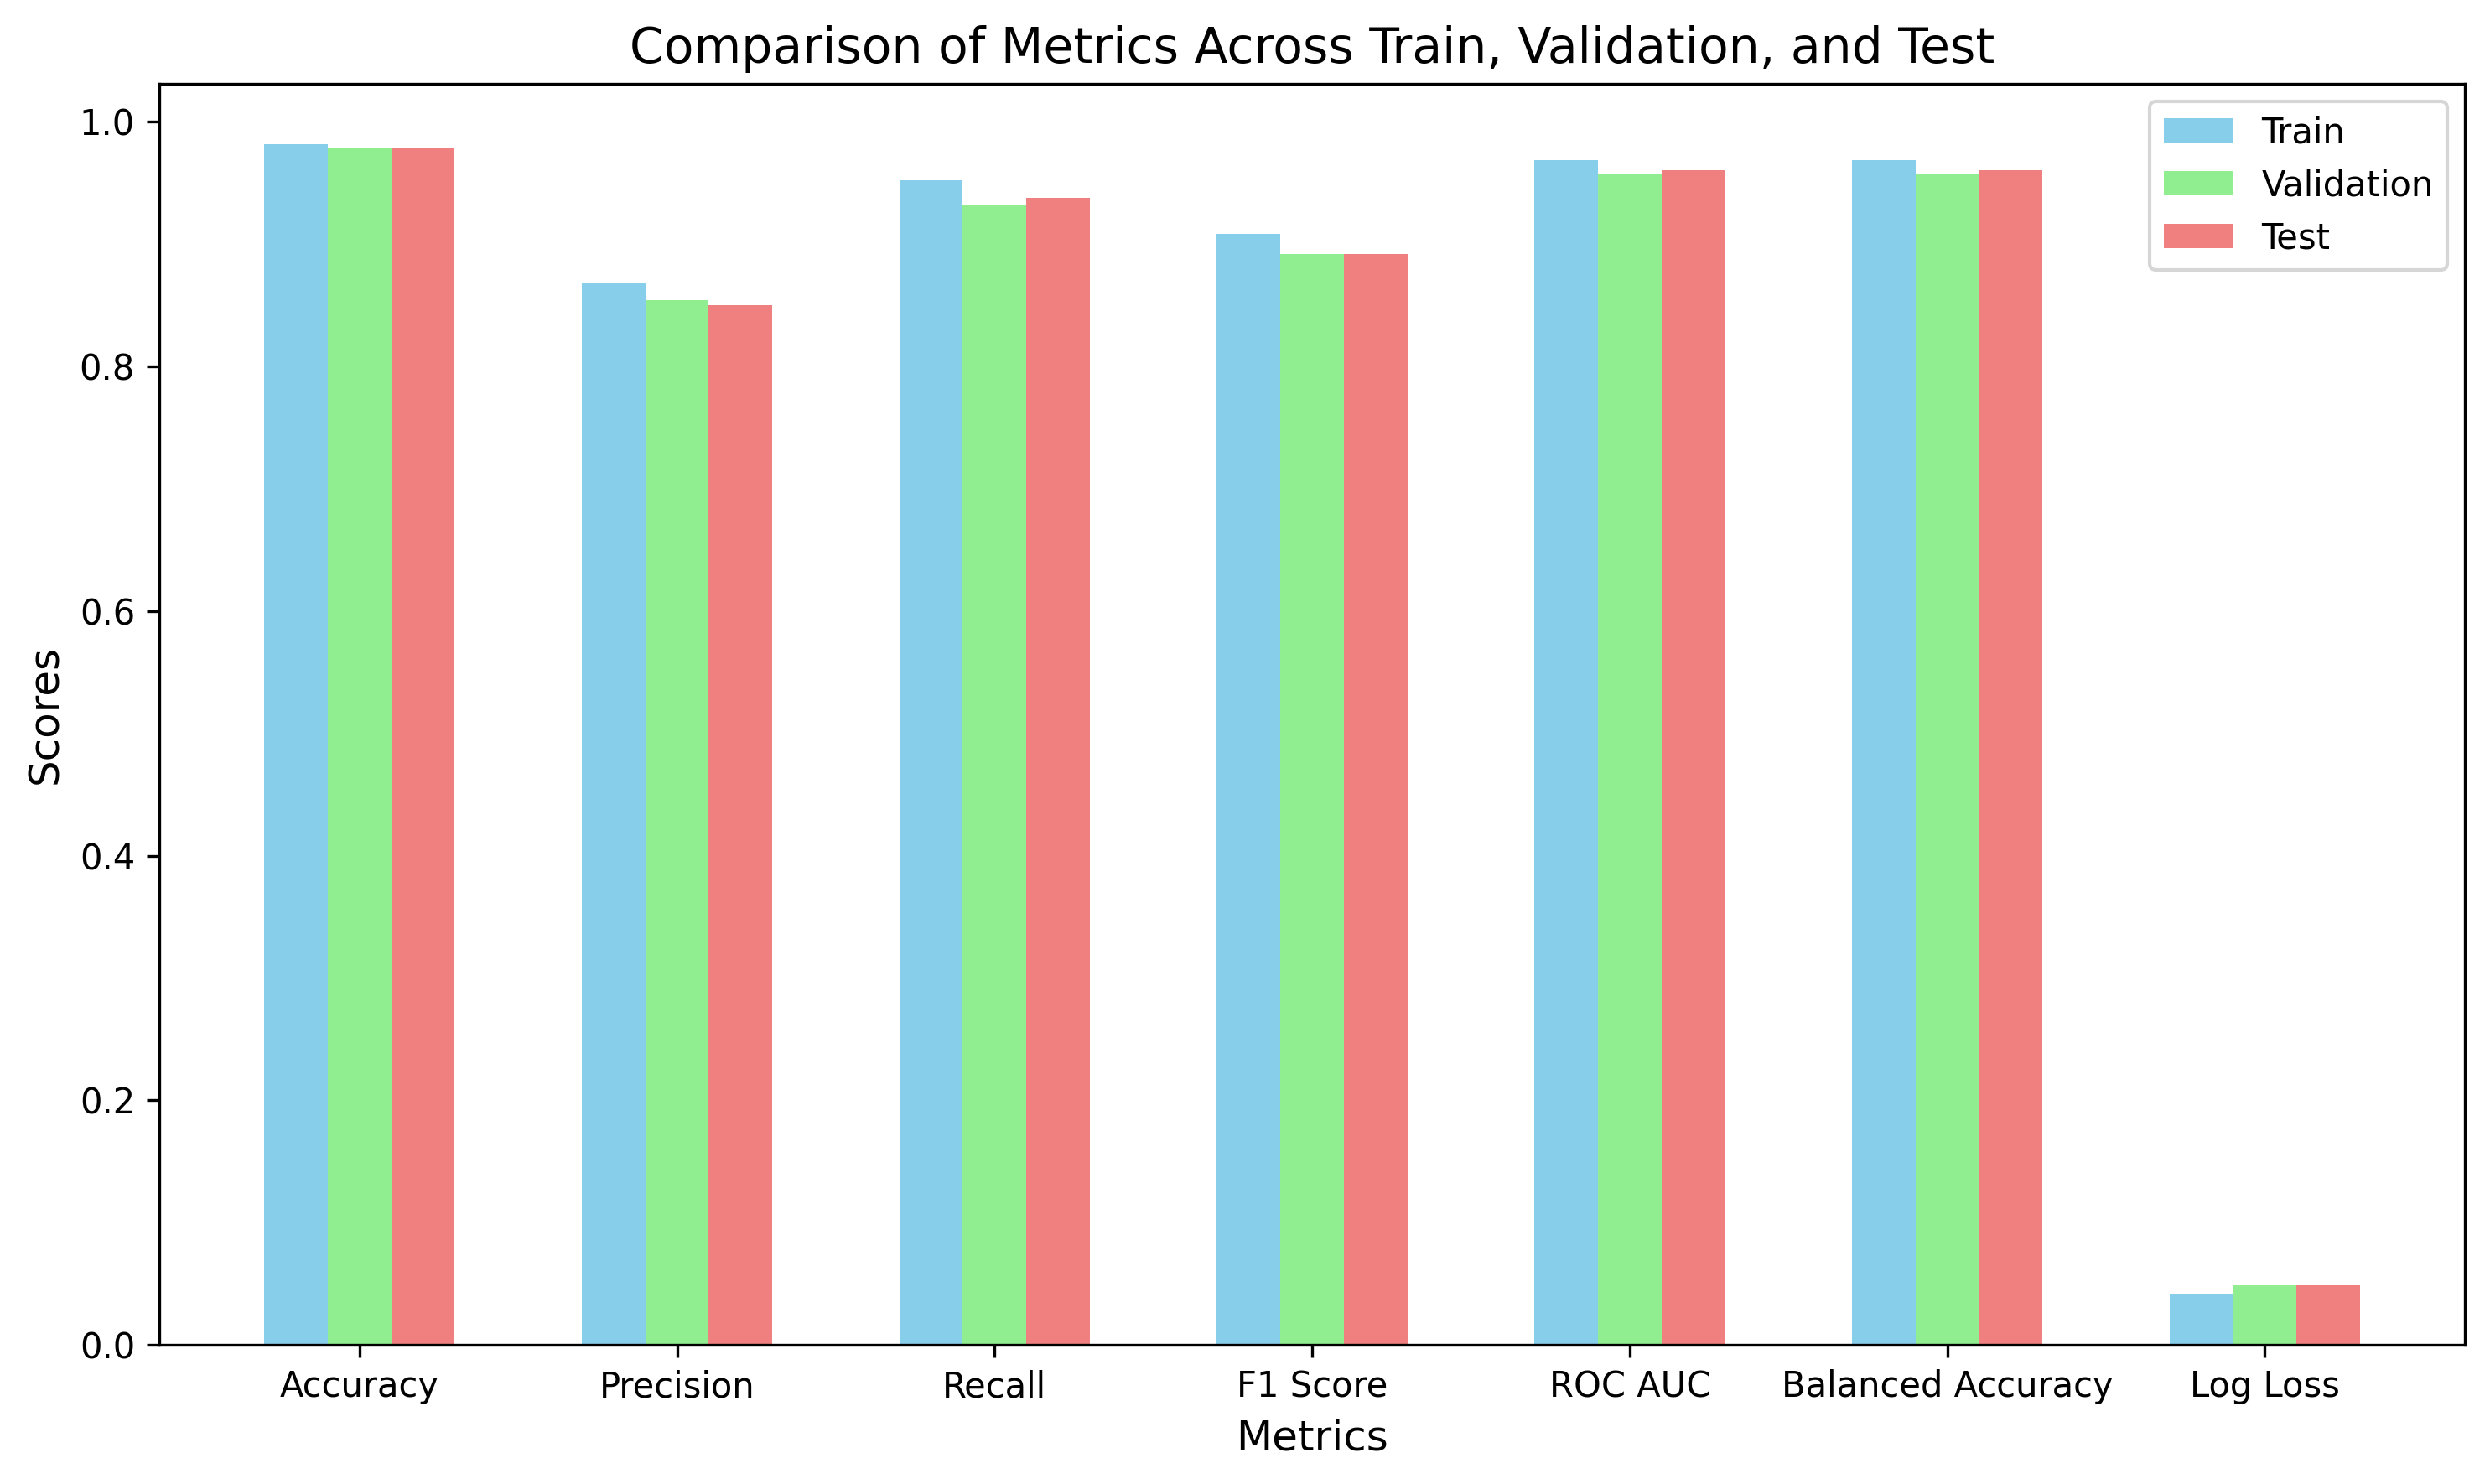

In [32]:
# Define metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Balanced Accuracy', 'Log Loss']
train_scores = [accuracy_train, precision_train, recall_train, f1_train, roc_auc_train, balanced_acc_train, log_loss_train]
val_scores = [accuracy_val, precision_val, recall_val, f1_val, roc_auc_val, balanced_acc_val, log_loss_val]
test_scores = [accuracy_test, precision_test, recall_test, f1_test, roc_auc_test, balanced_acc_test, log_loss_test]

# Plot the bar graph
plt.figure(figsize=(10, 6), dpi=300)  # Set figure size and resolution
x = np.arange(len(metrics))  # The label locations
width = 0.2  # Width of the bars

# Create bars for each set of scores
plt.bar(x - width, train_scores, width, label='Train', color='skyblue')
plt.bar(x, val_scores, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_scores, width, label='Test', color='lightcoral')

# Add labels and title
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Comparison of Metrics Across Train, Validation, and Test', fontsize=14)
plt.xticks(x, metrics, fontsize=10)
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

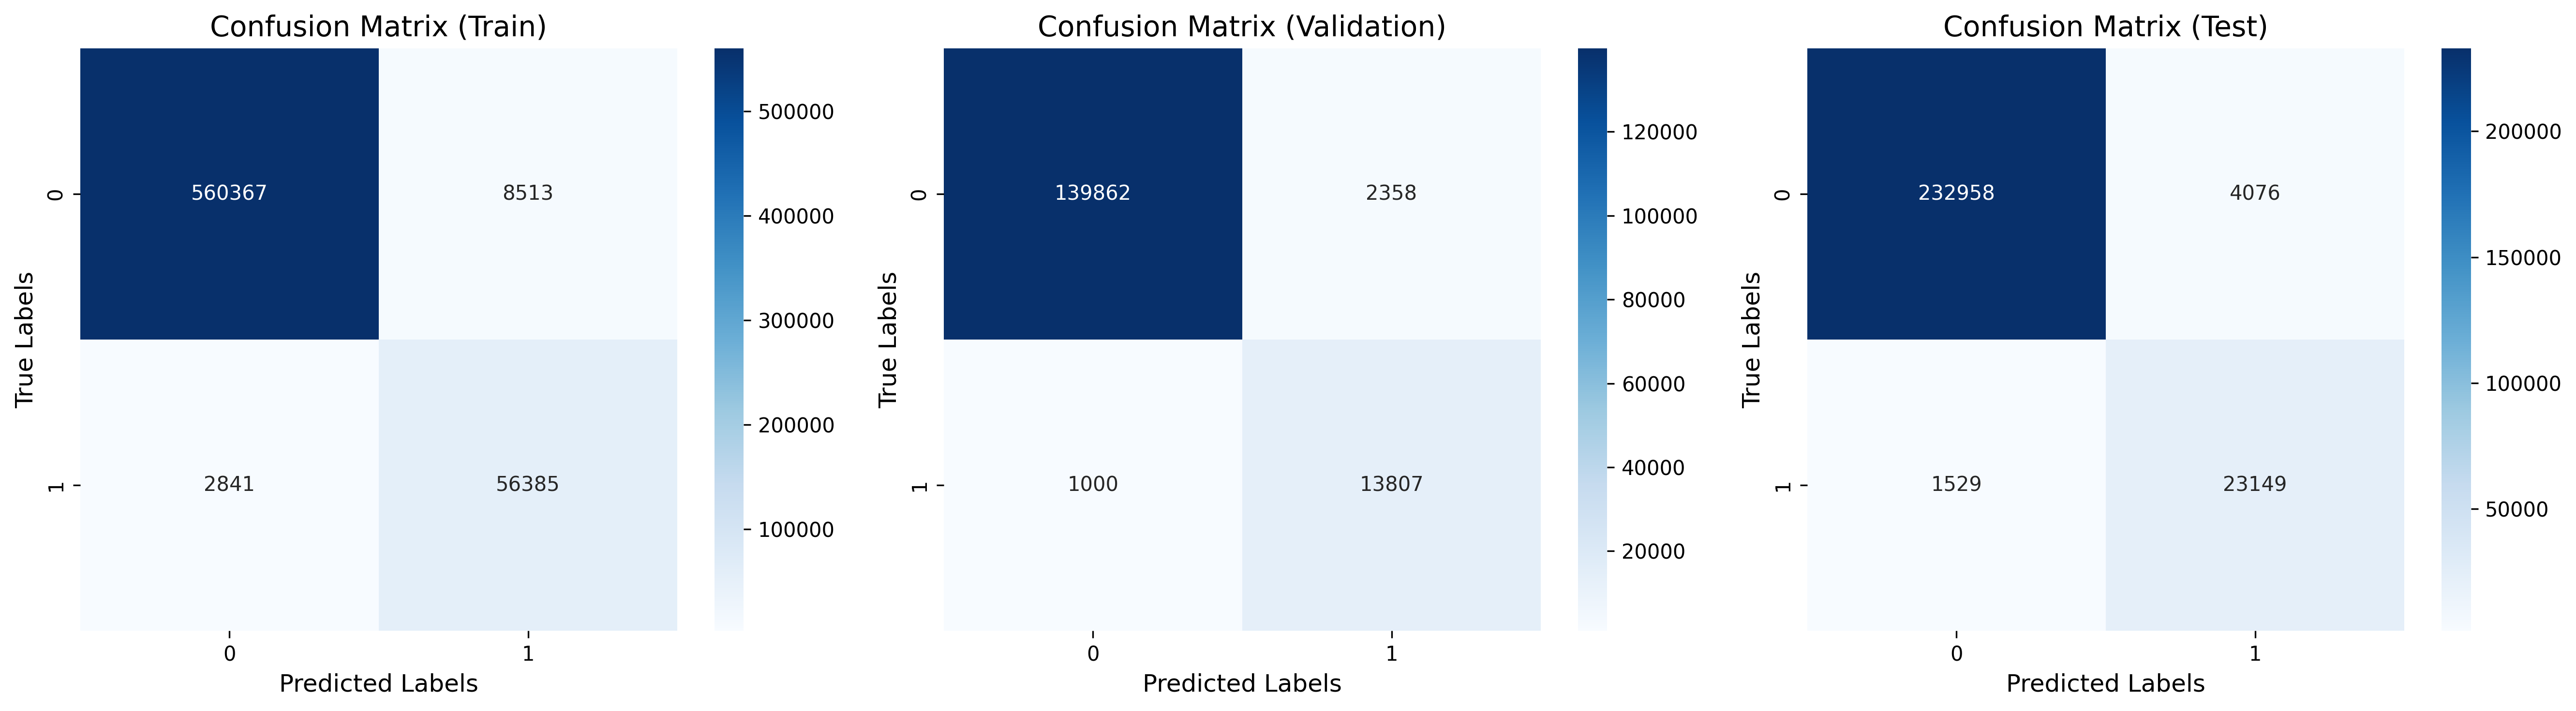

In [33]:
# Plot confusion matrices for Train, Validation, and Test data
fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

# Confusion Matrix for Training Data
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)', fontsize=14)
ax[0].set_xlabel('Predicted Labels', fontsize=12)
ax[0].set_ylabel('True Labels', fontsize=12)
ax[0].tick_params(axis='both', labelsize=10)

# Confusion Matrix for Validation Data
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Validation)', fontsize=14)
ax[1].set_xlabel('Predicted Labels', fontsize=12)
ax[1].set_ylabel('True Labels', fontsize=12)
ax[1].tick_params(axis='both', labelsize=10)

# Confusion Matrix for Test Data
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', ax=ax[2])
ax[2].set_title('Confusion Matrix (Test)', fontsize=14)
ax[2].set_xlabel('Predicted Labels', fontsize=12)
ax[2].set_ylabel('True Labels', fontsize=12)
ax[2].tick_params(axis='both', labelsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

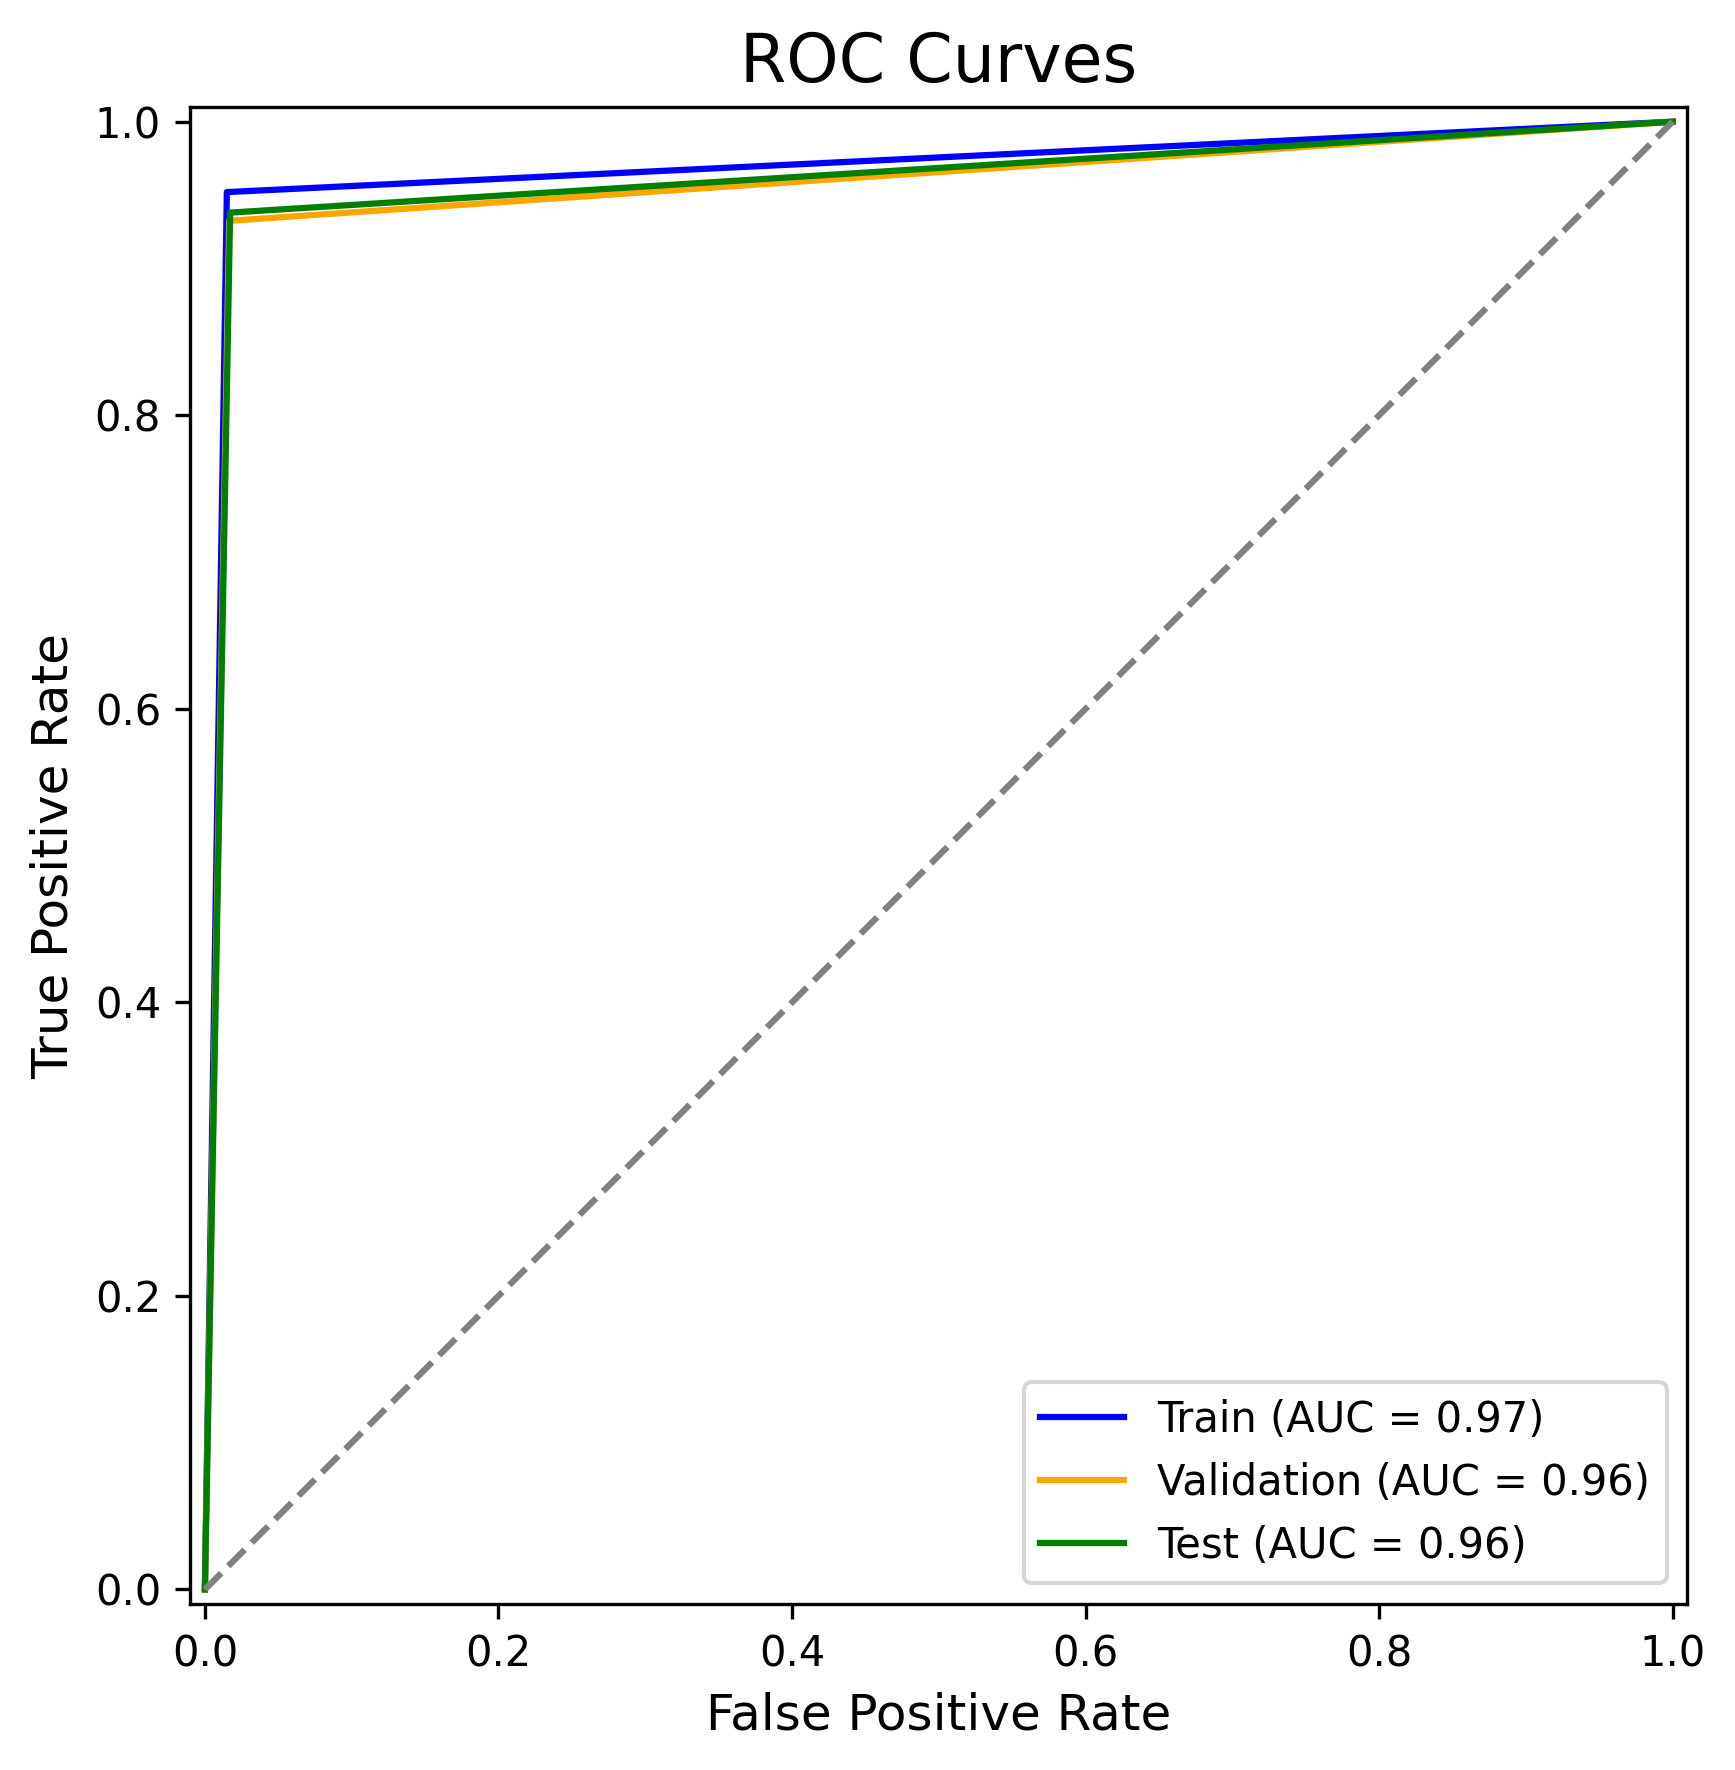

In [37]:
# Plot ROC curves for Train, Validation, and Test data
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)

# ROC Curve for Training Data
RocCurveDisplay.from_predictions(y_train_final['target'], y_pred_train, ax=ax, name='Train', color='blue')

# ROC Curve for Validation Data
RocCurveDisplay.from_predictions(y_val_final['target'], y_pred_val, ax=ax, name='Validation', color='orange')

# ROC Curve for Test Data
RocCurveDisplay.from_predictions(y_test_final['target'], y_pred_test_final, ax=ax, name='Test', color='green')

# Adding title and labels
ax.set_title('ROC Curves', fontsize=16)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.plot([0, 1], [0, 1], 'k--', color='grey')  # Add a diagonal line for chance level
ax.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()

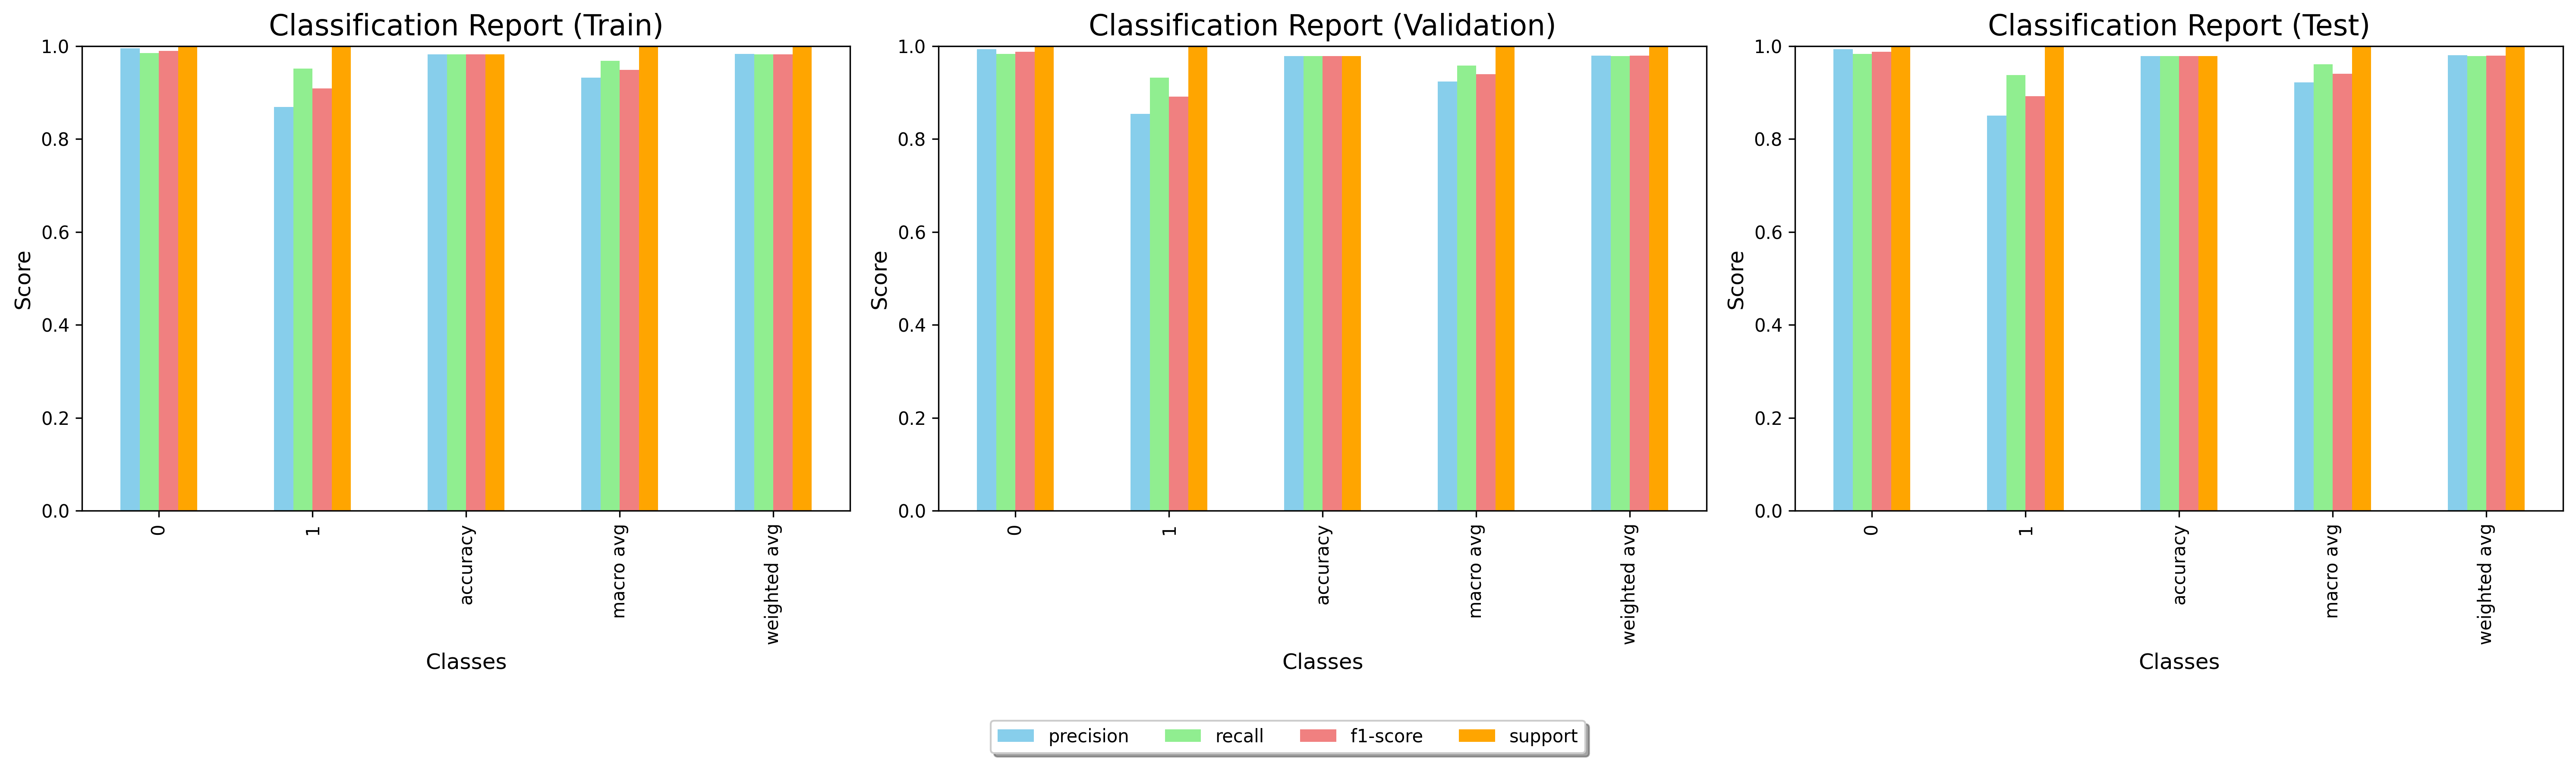

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Convert classification report string to DataFrame with output_dict=True
train_report = pd.DataFrame(classification_report(y_train_final['target'], y_pred_train, output_dict=True)).transpose()
val_report = pd.DataFrame(classification_report(y_val_final['target'], y_pred_val, output_dict=True)).transpose()
test_report = pd.DataFrame(classification_report(y_test_final['target'], y_pred_test_final, output_dict=True)).transpose()

# Plot Classification Report for each class (Train, Validation, Test)
fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=300)

# List of metrics to plot
metrics = ['precision', 'recall', 'f1-score', 'support']

# Function to plot reports
def plot_classification_report(report, ax, title):
    report[['precision', 'recall', 'f1-score', 'support']].plot(
        kind='bar', ax=ax, color=['skyblue', 'lightgreen', 'lightcoral', 'orange'], legend=False)
    ax.set_title(title, fontsize=16)
    ax.set_ylim([0, 1])  # Set y-axis limits for metrics
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Classes', fontsize=12)

# Plot each report
plot_classification_report(train_report, ax[0], 'Classification Report (Train)')
plot_classification_report(val_report, ax[1], 'Classification Report (Validation)')
plot_classification_report(test_report, ax[2], 'Classification Report (Test)')

# Add a common legend below the subplots
fig.legend(metrics, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01), fancybox=True, shadow=True)

# Adjust the layout to prevent overlap
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Create space for the legend
plt.show()

## Thank You